In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
df = pd.read_csv("sample_data_year.csv")

C:\Users\siddh\AppData\Local\Temp\ipykernel_11888\1474016976.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("sample_data_year.csv")


In [4]:
df.head()

,Time,Rev_ME,CppPitch,FO_ME_Cons,FO_GE_Cons,Wind_Direction,Wind_Speed,Ship_Speed,Fore_Draft,Aft_Draft,...,LCD_ABNOR4,LCD_ABNOR5,LCD_ABNOR6,ILS_ABNOR,SENSOR_ABNOR,INITIAL_SET,STAND_BY_ETHRNET_LINE,STAND_BY_ILS_LINE,ILS_ETH_LINE1,ILS_ETH_LINE2
0,04-03-2024 00:00,102.2,23.0,80237,4421,47,9.7,17.2,5.92,6.8,...,0,0,0,0,0,0,0,0,0,0
1,04-03-2024 00:01,102.2,23.0,80262,4420,47,7.7,17.2,6.04,6.73,...,0,0,0,0,0,0,0,0,0,0
2,04-03-2024 00:02,102.2,23.0,80286,4419,49,8.3,17.2,5.99,6.78,...,0,0,0,0,0,0,0,0,0,0
3,04-03-2024 00:03,101.9,22.7,80309,4419,44,7.7,17.2,6.04,6.71,...,0,0,0,0,0,0,0,0,0,0
4,04-03-2024 00:04,102.1,22.9,80332,4419,44,8.2,17.2,5.98,6.8,...,0,0,0,0,0,0,0,0,0,0


In [26]:
    df['Time'] = pd.to_datetime(df['Time'], format='%d-%m-%Y %H:%M')
    df = df.sort_values('Time').reset_index(drop=True)
    # Fuel and other numeric columns
    cols_to_clean = ['FO_ME_Cons', 'FO_GE_Cons', 'Ship_Speed', 'CppPitch', 'Wind_Speed',
                    'HEEL', 'Fore_Draft', 'Aft_Draft']

    for col in cols_to_clean:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        
    # Compute fuel consumption properly

    # FO_ME_Cons: increasing (normal)
    fuel_me = df['FO_ME_Cons'].diff().clip(lower=0)

    # FO_GE_Cons: decreasing → reverse the diff
    fuel_ge = (-df['FO_GE_Cons'].diff()).clip(lower=0)

    # Total fuel per minute
    df['Fuel_Liters'] = fuel_me + fuel_ge


In [19]:
df.fillna(method='ffill', inplace=True)
df.dropna(inplace=True)
# Define speed threshold for considering the ship as 'in motion'
speed_threshold = 0.5  # knots

# Filter out rows where ship was at rest (speed near 0)
moving_df = df[df['Ship_Speed'] > speed_threshold].copy()
# Trim & Average Draft
df['Trim'] = df['Aft_Draft'] - df['Fore_Draft']
df['Avg_Draft'] = (df['Fore_Draft'] + df['Aft_Draft']) / 2

#Distance per minute (knots / 60 = NM per minute)
df['Distance_NM'] = df['Ship_Speed'] / 60

# Drop any extreme values again, if needed
moving_df = moving_df[
    (moving_df['Fuel_Liters'] <= 30) &
    (moving_df['Distance_NM'] <= 1.5) &
    (moving_df['Ship_Speed'] <= 25)
]

# Convert fuel to CO₂ emissions
FUEL_DENSITY = 0.991  # kg/L
CO2_FACTOR = 3.114  # g CO2 / g fuel
fuel_kg = df['Fuel_Liters'] * FUEL_DENSITY
df['CO2_Emission_g'] = fuel_kg * 1000 * CO2_FACTOR

# --- Outlier Detection ---
# Using Interquartile Range (IQR) for outlier filtering
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Apply outlier filtering on key continuous variables
df = remove_outliers_iqr(df, 'Fuel_Liters')
df = remove_outliers_iqr(df, 'Distance_NM')
df = remove_outliers_iqr(df, 'Ship_Speed')


C:\Users\siddh\AppData\Local\Temp\ipykernel_11888\4016223029.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [20]:
# Recalculate totals after cleaning
total_fuel_liters = df['Fuel_Liters'].sum()
total_co2_grams = df['CO2_Emission_g'].sum()
total_distance_nm = df['Distance_NM'].sum()

# --- Final CII Calculation ---
GT = 14052  # Confirmed ship capacity
cii_value = total_co2_grams / (GT * total_distance_nm)

# --- Output ---
print("="*40)
print("✅ Final Cleaned CII Calculation Summary")
print("="*40)
print(f"Duration: {df['Time'].iloc[0]} to {df['Time'].iloc[-1]}")
print(f"Data points: {len(df)}")
print(f"Total Fuel (L): {total_fuel_liters:,.2f}")
print(f"Total CO₂ (g): {total_co2_grams:,.2f}")
print(f"Total Distance (NM): {total_distance_nm:,.2f}")
print(f"Final Annual CII: {cii_value:.4f}")
print("="*40)

✅ Final Cleaned CII Calculation Summary
Duration: 2024-03-04 00:01:00 to 2025-03-29 11:49:00
Data points: 511192
Total Fuel (L): 8,705,737.00
Total CO₂ (g): 26,865,678,032.84
Total Distance (NM): 97,039.74
Final Annual CII: 19.7020


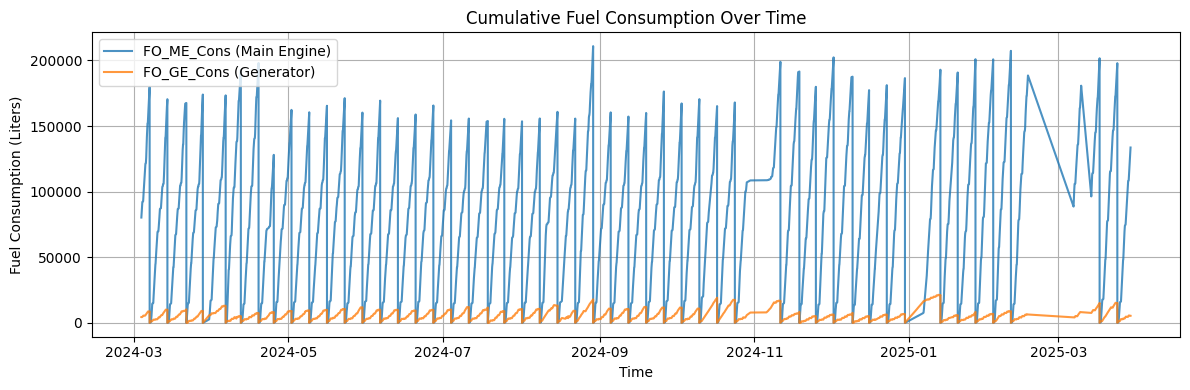

In [12]:
plt.figure(figsize=(12, 4))
plt.plot(df['Time'], df['FO_ME_Cons'], label='FO_ME_Cons (Main Engine)', alpha=0.8)
plt.plot(df['Time'], df['FO_GE_Cons'], label='FO_GE_Cons (Generator)', alpha=0.8)
plt.title('Cumulative Fuel Consumption Over Time')
plt.xlabel('Time')
plt.ylabel('Fuel Consumption (Liters)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


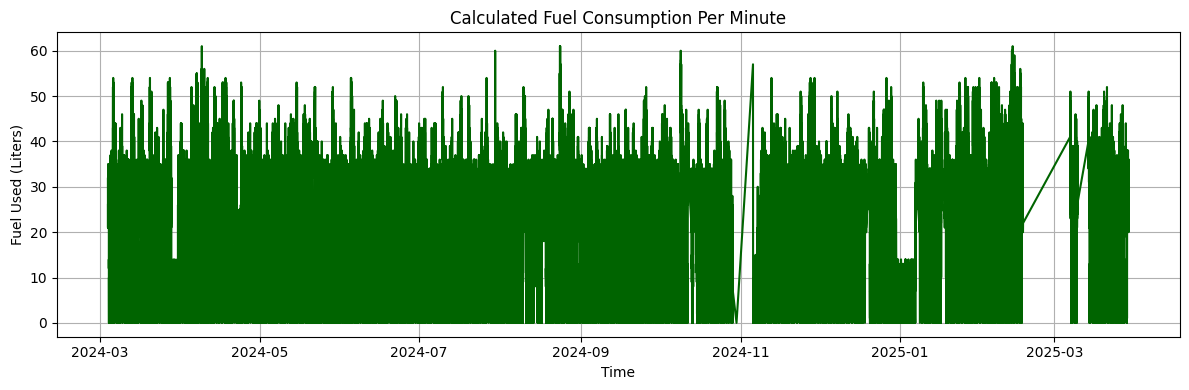

In [14]:
plt.figure(figsize=(12, 4))
plt.plot(df['Time'], df['Fuel_Liters'], color='darkgreen')
plt.title('Calculated Fuel Consumption Per Minute')
plt.xlabel('Time')
plt.ylabel('Fuel Used (Liters)')
plt.grid(True)
plt.tight_layout()
plt.show()

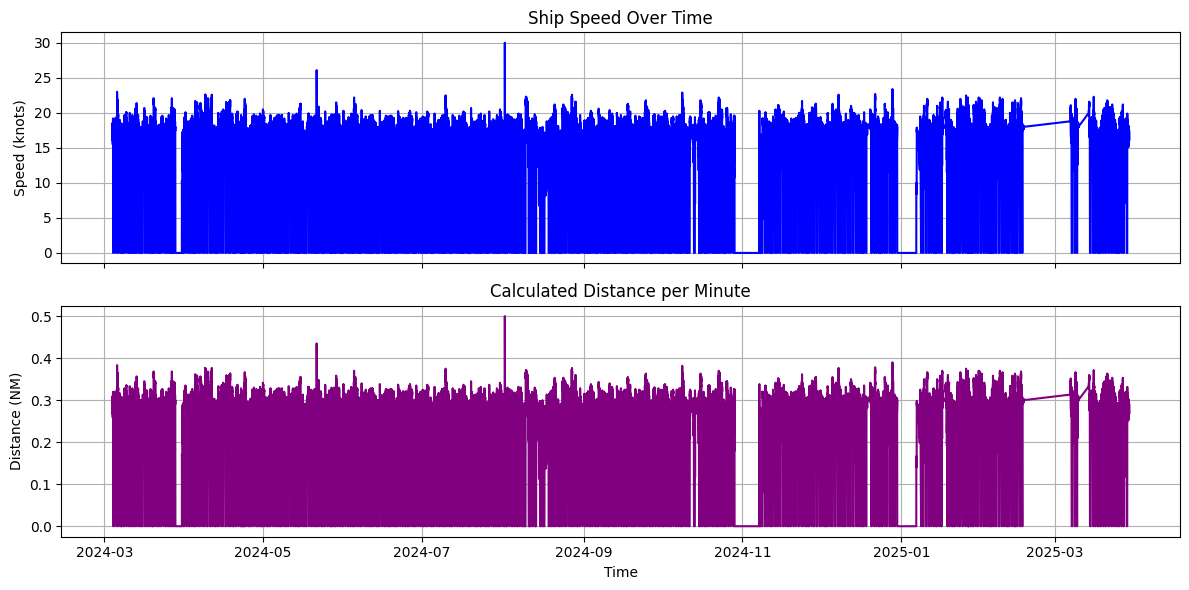

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
ax[0].plot(df['Time'], df['Ship_Speed'], label='Speed (knots)', color='blue')
ax[0].set_ylabel("Speed (knots)")
ax[0].set_title("Ship Speed Over Time")
ax[0].grid()

ax[1].plot(df['Time'], df['Distance_NM'], label='Distance per Min (NM)', color='purple')
ax[1].set_ylabel("Distance (NM)")
ax[1].set_title("Calculated Distance per Minute")
ax[1].set_xlabel("Time")
ax[1].grid()

plt.tight_layout()
plt.show()


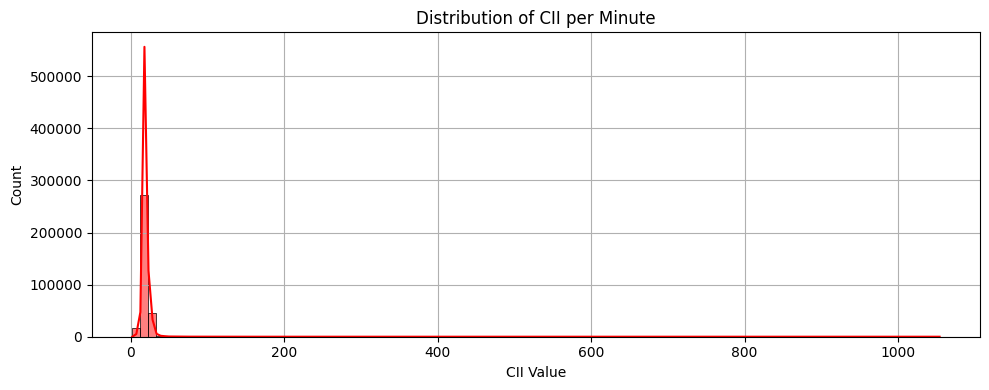

In [21]:
cii_per_minute = df['CO2_Emission_g'] / (14052 * df['Distance_NM'])
plt.figure(figsize=(10, 4))
sns.histplot(cii_per_minute, bins=100, kde=True, color='red')
plt.title("Distribution of CII per Minute")
plt.xlabel("CII Value")
plt.grid(True)
plt.tight_layout()
plt.show()


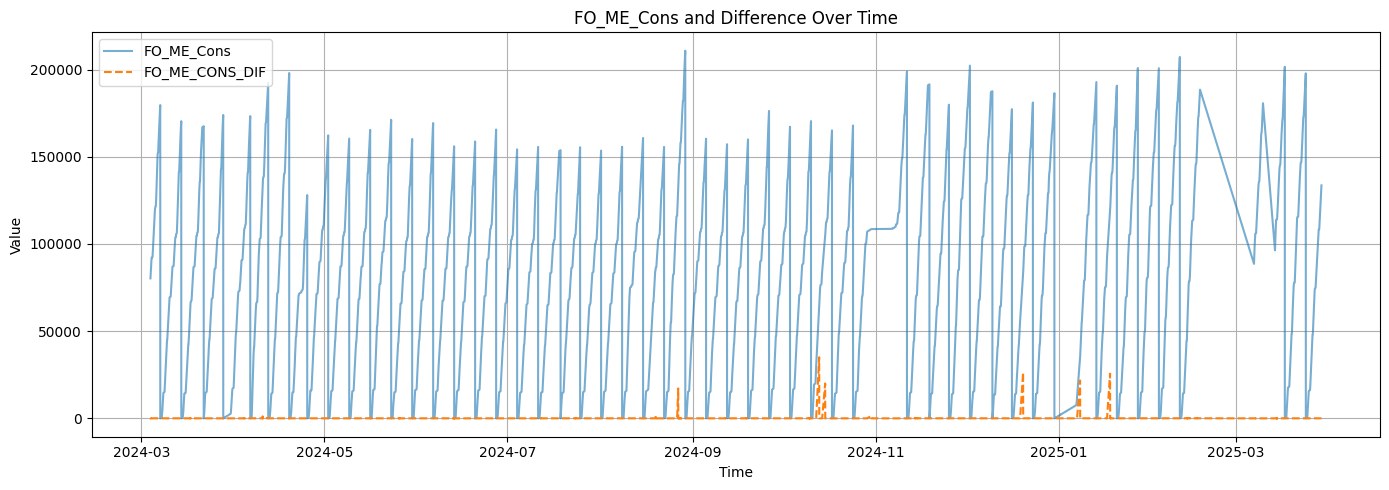

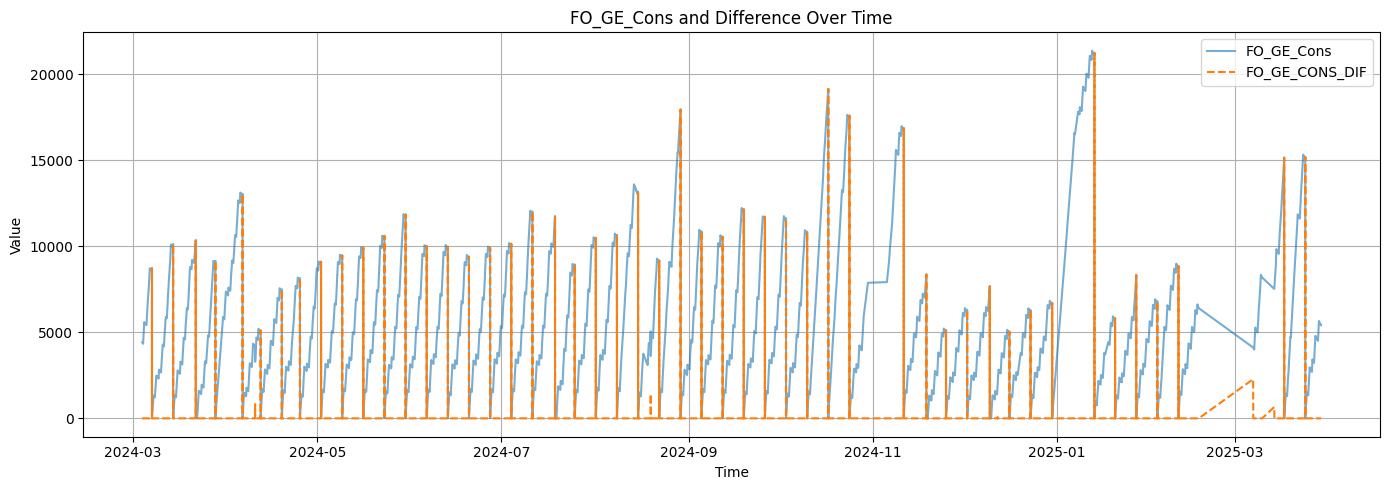

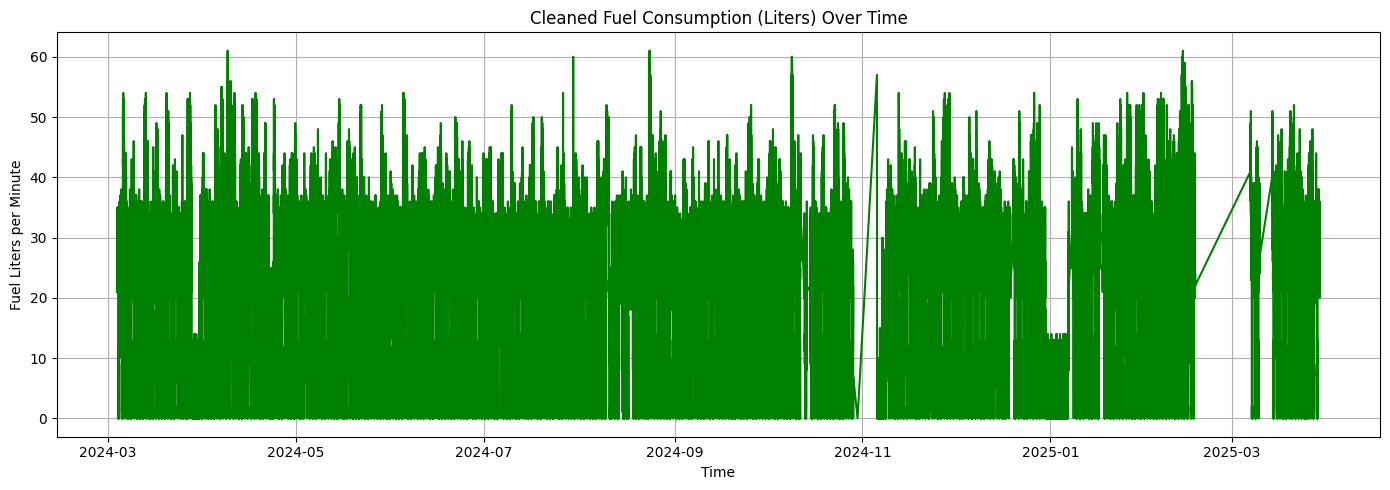

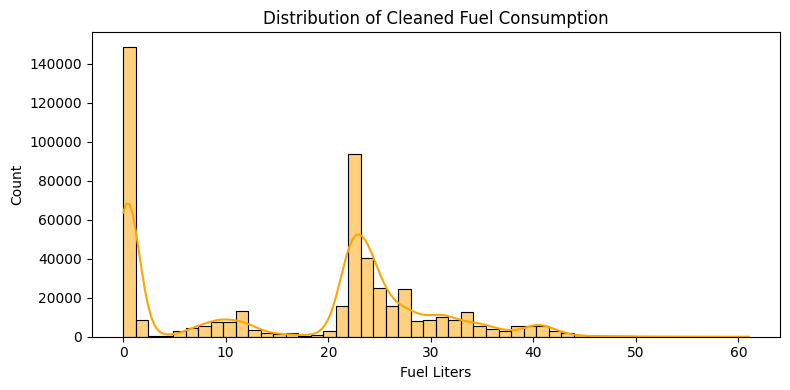

In [24]:
# Create FO_ME_CONS_DIF and FO_GE_CONS_DIF (already cleaned)
df['FO_ME_CONS_DIF'] = df['FO_ME_Cons'].diff().clip(lower=0)
df['FO_GE_CONS_DIF'] = (-df['FO_GE_Cons'].diff()).clip(lower=0)

# Plot FO_ME_Cons and its difference
plt.figure(figsize=(14, 5))
plt.plot(df['Time'], df['FO_ME_Cons'], label='FO_ME_Cons', alpha=0.6)
plt.plot(df['Time'], df['FO_ME_CONS_DIF'], label='FO_ME_CONS_DIF', linestyle='--')
plt.title("FO_ME_Cons and Difference Over Time")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot FO_GE_Cons and its difference
plt.figure(figsize=(14, 5))
plt.plot(df['Time'], df['FO_GE_Cons'], label='FO_GE_Cons', alpha=0.6)
plt.plot(df['Time'], df['FO_GE_CONS_DIF'], label='FO_GE_CONS_DIF', linestyle='--')
plt.title("FO_GE_Cons and Difference Over Time")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot cleaned Fuel_Liters over time
plt.figure(figsize=(14, 5))
plt.plot(df['Time'], df['Fuel_Liters'], label='Fuel_Liters', color='green')
plt.title("Cleaned Fuel Consumption (Liters) Over Time")
plt.xlabel("Time")
plt.ylabel("Fuel Liters per Minute")
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Histogram to show spread
plt.figure(figsize=(8, 4))
sns.histplot(df['Fuel_Liters'], bins=50, kde=True, color='orange')
plt.title("Distribution of Cleaned Fuel Consumption")
plt.xlabel("Fuel Liters")
plt.tight_layout()
plt.show()
